In [16]:
import os
import torch
import torchvision
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import json
from vis_utils import *
from model_def import *
from model_train import *
from net_reduce import *
%matplotlib inline

In [2]:
SIMIL_THRESH = 0.9
LAYER_CURR = 'fc1'
LAYER_NEXT = 'fc2'

In [3]:
# load in a pre-trained 500-layer network
expName = 'cifar-mlp-v1_w1-500'
expDir = os.path.join('./data', expName)
w1 = 500 # change conv1 dim
w2 = 100
net = MLP(input_dim=3072, fc1_dim=w1, fc2_dim=w2)
net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))

## Perturb (re-initialize) filters

In [4]:
# find CCs
layer_curr_weights = get_param(net, LAYER_CURR+'.weight')
similMat, _ = get_layer_cosine_similarity(net, LAYER_CURR+'.weight') # returned as numpy arrays
adj_mat = np.greater(similMat, SIMIL_THRESH)
cc_list, n_comps = get_adjmat_conn_comp(adj_mat)

In [5]:
# Perturbing lowest-norm filter in each group to a random init.
init_sigma = 0.003
param_dict = net.state_dict()
param_dict[LAYER_CURR+'.weight'].size()

for i in range(len(cc_list)):
    w_g = layer_curr_weights.numpy()[cc_list[i]]
    sz = w_g.shape
    if sz[0] > 2:
        min_index = np.argmin([np.linalg.norm(x, ord=2) for x in w_g])
        filter_id = cc_list[i][min_index]
        # print cc_list[i][min_index]
        # print param_dict[LAYER_CURR+'.weight'][cc_list[i][min_index]].size()
        param_dict[LAYER_CURR+'.weight'][filter_id] = \
            init_sigma * torch.randn(1, sz[1])

net.load_state_dict(param_dict)

In [9]:
# visualize filters after perturbing
outDir = os.path.join(expDir, 'perturbed_filters')
if not os.path.exists(outDir):
        os.makedirs(outDir)
        
for i in range(len(cc_list)):
    w_g = layer_curr_weights.numpy()[cc_list[i]]
    sz = w_g.shape
    
    if sz[0] > 2:
        f = vis_linear_weights(w_g)
        f.savefig(os.path.join(outDir, ('%d.png' % i)), \
                     bbox_inches='tight')
        plt.close(f)

## Re-train network

In [15]:
# New experiment folder for the re-training iterations
expName = expName + '-retrain-control-lr=0.01'
batchSize = 100

expDir = os.path.join('./data', expName)
if not os.path.exists(expDir):
    os.makedirs(expDir)

# setup and load CIFAR dataset
trainloader, testloader, classes = setup_cifar_data_mlp(batchSize)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# visualize filters after perturbing -- in "re-training" expt folder
outDir = os.path.join(expDir, 'perturbed_filters')
if not os.path.exists(outDir):
        os.makedirs(outDir)
        
for i in range(len(cc_list)):
    w_g = layer_curr_weights.numpy()[cc_list[i]]
    sz = w_g.shape
    
    if sz[0] > 2:
        f = vis_linear_weights(w_g)
        f.savefig(os.path.join(outDir, ('%d.png' % i)), \
                     bbox_inches='tight')
        plt.close(f)
        

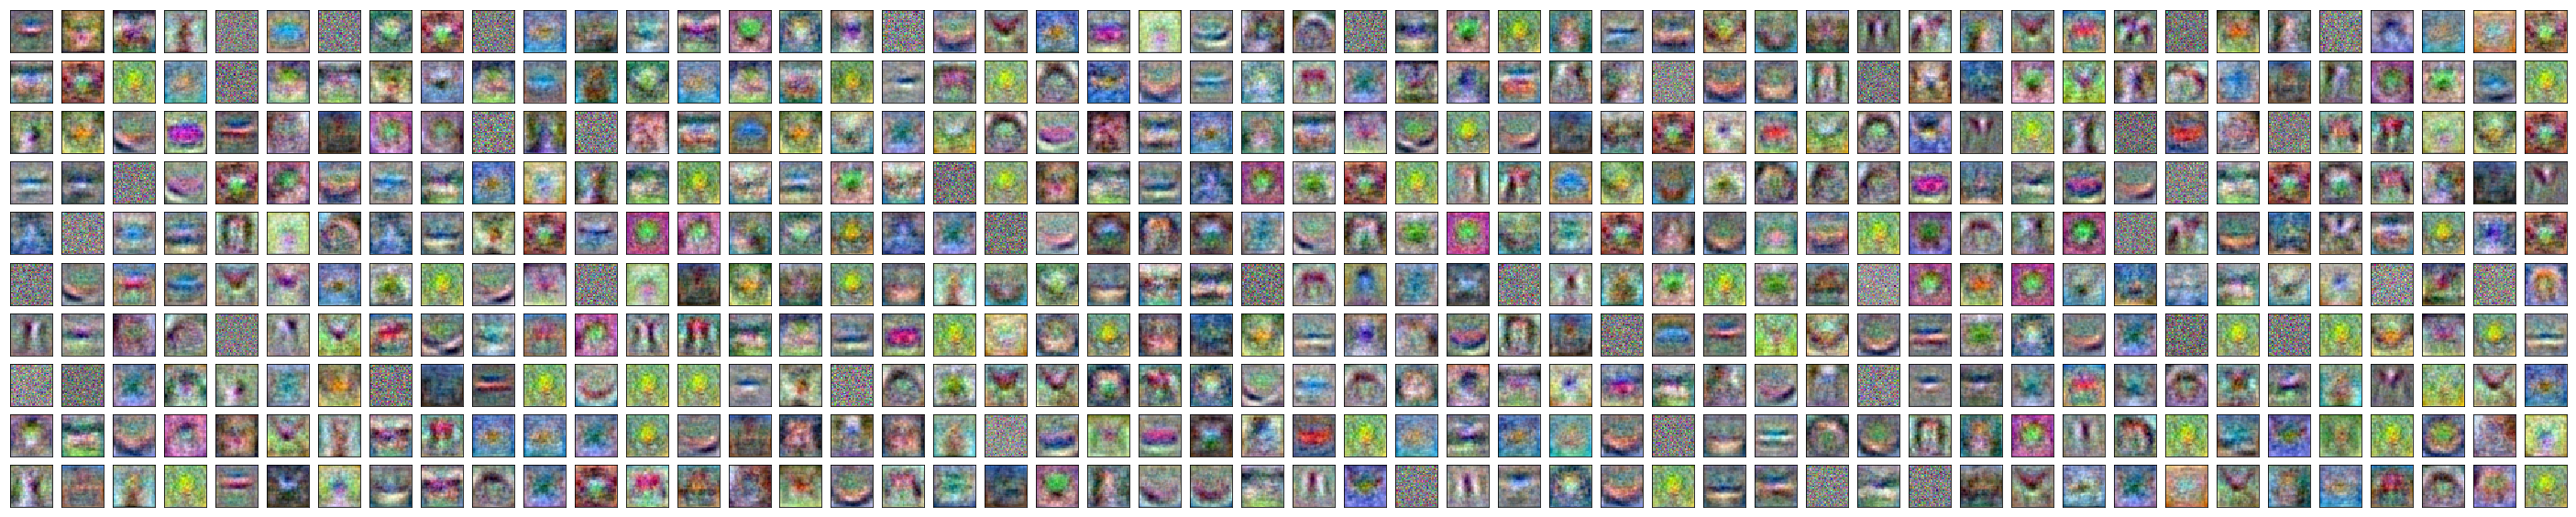

In [7]:
# Visualize all first layer filters
net.cpu()
param_dict = net.state_dict()
w_fc1 = param_dict['fc1.weight']
w_fc1 = w_fc1.numpy()
f = vis_linear_weights(w_fc1, num_cols=50) # MLP
f.savefig(os.path.join(expDir,'mlp-filter-init.png'), 
                        bbox_inches='tight')

In [14]:
# Train the network

from torch.optim.lr_scheduler import StepLR
import json

# hyper-params
useGpu = True
seed = 0  # for repeatable results
modelPath = []
numEpochs = 70
learningRate = 0.01
numBatchesPerEpoch = len(trainloader.dataset) // batchSize 
momentum = 0.9
weight_decay = 0.018 # pretty high L2-regularization (smaller generalization gap, smoother-looking filters)
gamma = 0.9 # decrement learning rate by this factor at every epoch
verboseFrequency = 250
doVisFilter = False


# save training config
cfg = {'useGpu': useGpu, 'numEpochs': numEpochs, 'learningRate': learningRate, \
       'batchSize': batchSize, 'momentum': momentum, 'weight_decay': weight_decay, \
       'gamma': gamma, 'verboseFrequency': verboseFrequency, 'doVisFilter': doVisFilter}


# set random seed
torch.default_generator.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Define a Loss function and optimizer settings
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learningRate, momentum=momentum, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=gamma)

if not os.path.isfile(os.path.join(expDir, 'net-trained.dat')):
    # cfg = json.load(file(os.path.join(expDir,'train_config.json'), 'r'))
    with open(os.path.join(expDir,'train_config.json'), 'w') as config_file :
        json.dump(cfg, config_file, indent=4, separators=(',', ': '), sort_keys=True)
    
    # Train the network
    train_cifar_net(net, trainloader, testloader, criterion, (optimizer,lr_scheduler), \
                    expDir, batchSize=batchSize, \
                    numEpochs=numEpochs, useGpu=useGpu, fixFilterList=[], \
                    verboseFrequency=verboseFrequency, \
                    doVisFilter=doVisFilter)

    # Save the network
    torch.save(net.state_dict(), os.path.join(expDir, 'net-trained.dat'))
else:
    print 'Loading network state dict from file.'
    net.load_state_dict(torch.load(os.path.join(expDir, 'net-trained.dat')))
    print 'Done.'

    


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:   0 batch:   250 loss: 1.594 accu: 0.465 lr: 0.030000
epoch:   0 batch:   500 loss: 1.611 accu: 0.454 lr: 0.030000


  1%|▏         | 1/70 [00:12<14:16, 12.41s/it]

epoch:   1 batch:   250 loss: 1.595 accu: 0.455 lr: 0.027000
epoch:   1 batch:   500 loss: 1.608 accu: 0.450 lr: 0.027000


  3%|▎         | 2/70 [00:25<14:10, 12.51s/it]

epoch:   2 batch:   250 loss: 1.587 accu: 0.455 lr: 0.024300
epoch:   2 batch:   500 loss: 1.590 accu: 0.451 lr: 0.024300


  4%|▍         | 3/70 [00:38<14:09, 12.68s/it]

epoch:   3 batch:   250 loss: 1.561 accu: 0.465 lr: 0.021870
epoch:   3 batch:   500 loss: 1.572 accu: 0.464 lr: 0.021870


  6%|▌         | 4/70 [00:50<13:54, 12.64s/it]

epoch:   4 batch:   250 loss: 1.561 accu: 0.466 lr: 0.019683
epoch:   4 batch:   500 loss: 1.549 accu: 0.472 lr: 0.019683


  7%|▋         | 5/70 [01:02<13:28, 12.44s/it]

epoch:   5 batch:   250 loss: 1.522 accu: 0.478 lr: 0.017715
epoch:   5 batch:   500 loss: 1.551 accu: 0.469 lr: 0.017715


  9%|▊         | 6/70 [01:14<13:08, 12.32s/it]

epoch:   6 batch:   250 loss: 1.524 accu: 0.477 lr: 0.015943
epoch:   6 batch:   500 loss: 1.523 accu: 0.476 lr: 0.015943


 10%|█         | 7/70 [01:31<14:22, 13.69s/it]

epoch:   7 batch:   250 loss: 1.505 accu: 0.485 lr: 0.014349
epoch:   7 batch:   500 loss: 1.517 accu: 0.487 lr: 0.014349


 11%|█▏        | 8/70 [01:45<14:15, 13.80s/it]

epoch:   8 batch:   250 loss: 1.494 accu: 0.490 lr: 0.012914
epoch:   8 batch:   500 loss: 1.500 accu: 0.488 lr: 0.012914


 13%|█▎        | 9/70 [01:58<13:42, 13.48s/it]

epoch:   9 batch:   250 loss: 1.467 accu: 0.498 lr: 0.011623
epoch:   9 batch:   500 loss: 1.499 accu: 0.490 lr: 0.011623


 14%|█▍        | 10/70 [02:11<13:18, 13.30s/it]

epoch:  10 batch:   250 loss: 1.477 accu: 0.493 lr: 0.010460
epoch:  10 batch:   500 loss: 1.469 accu: 0.498 lr: 0.010460


 16%|█▌        | 11/70 [02:24<13:04, 13.29s/it]

epoch:  11 batch:   250 loss: 1.448 accu: 0.506 lr: 0.009414
epoch:  11 batch:   500 loss: 1.470 accu: 0.495 lr: 0.009414


 17%|█▋        | 12/70 [02:37<12:50, 13.29s/it]

epoch:  12 batch:   250 loss: 1.449 accu: 0.506 lr: 0.008473
epoch:  12 batch:   500 loss: 1.454 accu: 0.502 lr: 0.008473


 19%|█▊        | 13/70 [02:50<12:24, 13.07s/it]

epoch:  13 batch:   250 loss: 1.431 accu: 0.511 lr: 0.007626
epoch:  13 batch:   500 loss: 1.450 accu: 0.506 lr: 0.007626


 20%|██        | 14/70 [03:03<12:02, 12.91s/it]

epoch:  14 batch:   250 loss: 1.411 accu: 0.517 lr: 0.006863
epoch:  14 batch:   500 loss: 1.446 accu: 0.502 lr: 0.006863


 21%|██▏       | 15/70 [03:15<11:45, 12.83s/it]

epoch:  15 batch:   250 loss: 1.416 accu: 0.517 lr: 0.006177
epoch:  15 batch:   500 loss: 1.431 accu: 0.509 lr: 0.006177


 23%|██▎       | 16/70 [03:27<11:23, 12.65s/it]

epoch:  16 batch:   250 loss: 1.400 accu: 0.520 lr: 0.005559
epoch:  16 batch:   500 loss: 1.419 accu: 0.512 lr: 0.005559


 24%|██▍       | 17/70 [03:40<11:05, 12.55s/it]

epoch:  17 batch:   250 loss: 1.386 accu: 0.526 lr: 0.005003
epoch:  17 batch:   500 loss: 1.414 accu: 0.515 lr: 0.005003


 26%|██▌       | 18/70 [03:52<10:55, 12.60s/it]

epoch:  18 batch:   250 loss: 1.387 accu: 0.524 lr: 0.004503
epoch:  18 batch:   500 loss: 1.402 accu: 0.518 lr: 0.004503


 27%|██▋       | 19/70 [04:05<10:42, 12.61s/it]

epoch:  19 batch:   250 loss: 1.378 accu: 0.528 lr: 0.004053
epoch:  19 batch:   500 loss: 1.387 accu: 0.524 lr: 0.004053


 29%|██▊       | 20/70 [04:18<10:29, 12.59s/it]

epoch:  20 batch:   250 loss: 1.362 accu: 0.538 lr: 0.003647
epoch:  20 batch:   500 loss: 1.390 accu: 0.521 lr: 0.003647


 30%|███       | 21/70 [04:31<10:22, 12.69s/it]

epoch:  21 batch:   250 loss: 1.358 accu: 0.538 lr: 0.003283
epoch:  21 batch:   500 loss: 1.380 accu: 0.527 lr: 0.003283


 31%|███▏      | 22/70 [04:44<10:14, 12.81s/it]

epoch:  22 batch:   250 loss: 1.355 accu: 0.539 lr: 0.002954
epoch:  22 batch:   500 loss: 1.370 accu: 0.529 lr: 0.002954


 33%|███▎      | 23/70 [04:56<09:52, 12.61s/it]

epoch:  23 batch:   250 loss: 1.352 accu: 0.537 lr: 0.002659
epoch:  23 batch:   500 loss: 1.359 accu: 0.537 lr: 0.002659


 34%|███▍      | 24/70 [05:09<09:49, 12.81s/it]

epoch:  24 batch:   250 loss: 1.343 accu: 0.541 lr: 0.002393
epoch:  24 batch:   500 loss: 1.353 accu: 0.538 lr: 0.002393


 36%|███▌      | 25/70 [05:22<09:44, 12.99s/it]

epoch:  25 batch:   250 loss: 1.344 accu: 0.543 lr: 0.002154
epoch:  25 batch:   500 loss: 1.342 accu: 0.539 lr: 0.002154


 37%|███▋      | 26/70 [05:35<09:24, 12.84s/it]

epoch:  26 batch:   250 loss: 1.329 accu: 0.547 lr: 0.001938
epoch:  26 batch:   500 loss: 1.345 accu: 0.536 lr: 0.001938


 39%|███▊      | 27/70 [05:47<09:07, 12.72s/it]

epoch:  27 batch:   250 loss: 1.326 accu: 0.546 lr: 0.001744
epoch:  27 batch:   500 loss: 1.338 accu: 0.543 lr: 0.001744


 40%|████      | 28/70 [06:00<08:54, 12.72s/it]

epoch:  28 batch:   250 loss: 1.323 accu: 0.549 lr: 0.001570
epoch:  28 batch:   500 loss: 1.334 accu: 0.544 lr: 0.001570


 41%|████▏     | 29/70 [06:13<08:43, 12.77s/it]

epoch:  29 batch:   250 loss: 1.320 accu: 0.548 lr: 0.001413
epoch:  29 batch:   500 loss: 1.326 accu: 0.548 lr: 0.001413


 43%|████▎     | 30/70 [06:26<08:35, 12.89s/it]

epoch:  30 batch:   250 loss: 1.317 accu: 0.552 lr: 0.001272
epoch:  30 batch:   500 loss: 1.321 accu: 0.547 lr: 0.001272


 44%|████▍     | 31/70 [06:40<08:32, 13.13s/it]

epoch:  31 batch:   250 loss: 1.312 accu: 0.550 lr: 0.001145
epoch:  31 batch:   500 loss: 1.319 accu: 0.549 lr: 0.001145


 46%|████▌     | 32/70 [06:52<08:09, 12.87s/it]

epoch:  32 batch:   250 loss: 1.313 accu: 0.553 lr: 0.001030
epoch:  32 batch:   500 loss: 1.311 accu: 0.554 lr: 0.001030


 47%|████▋     | 33/70 [07:05<07:53, 12.80s/it]

epoch:  33 batch:   250 loss: 1.305 accu: 0.559 lr: 0.000927
epoch:  33 batch:   500 loss: 1.311 accu: 0.547 lr: 0.000927


 49%|████▊     | 34/70 [07:17<07:36, 12.69s/it]

epoch:  34 batch:   250 loss: 1.296 accu: 0.558 lr: 0.000834
epoch:  34 batch:   500 loss: 1.315 accu: 0.550 lr: 0.000834


 50%|█████     | 35/70 [07:30<07:30, 12.87s/it]

epoch:  35 batch:   250 loss: 1.302 accu: 0.556 lr: 0.000751
epoch:  35 batch:   500 loss: 1.305 accu: 0.553 lr: 0.000751


 51%|█████▏    | 36/70 [07:42<07:08, 12.60s/it]

epoch:  36 batch:   250 loss: 1.303 accu: 0.555 lr: 0.000676
epoch:  36 batch:   500 loss: 1.299 accu: 0.555 lr: 0.000676


 53%|█████▎    | 37/70 [07:55<06:54, 12.57s/it]

epoch:  37 batch:   250 loss: 1.294 accu: 0.558 lr: 0.000608
epoch:  37 batch:   500 loss: 1.302 accu: 0.555 lr: 0.000608


 54%|█████▍    | 38/70 [08:07<06:40, 12.51s/it]

epoch:  38 batch:   250 loss: 1.301 accu: 0.558 lr: 0.000547
epoch:  38 batch:   500 loss: 1.291 accu: 0.556 lr: 0.000547


 56%|█████▌    | 39/70 [08:21<06:35, 12.75s/it]

epoch:  39 batch:   250 loss: 1.289 accu: 0.559 lr: 0.000493
epoch:  39 batch:   500 loss: 1.299 accu: 0.556 lr: 0.000493


 57%|█████▋    | 40/70 [08:38<06:59, 14.00s/it]

epoch:  40 batch:   250 loss: 1.291 accu: 0.559 lr: 0.000443
epoch:  40 batch:   500 loss: 1.294 accu: 0.558 lr: 0.000443


 59%|█████▊    | 41/70 [08:51<06:42, 13.90s/it]

epoch:  41 batch:   250 loss: 1.292 accu: 0.563 lr: 0.000399
epoch:  41 batch:   500 loss: 1.289 accu: 0.554 lr: 0.000399


 60%|██████    | 42/70 [09:05<06:25, 13.77s/it]

epoch:  42 batch:   250 loss: 1.288 accu: 0.556 lr: 0.000359
epoch:  42 batch:   500 loss: 1.290 accu: 0.562 lr: 0.000359


 61%|██████▏   | 43/70 [09:19<06:12, 13.81s/it]

epoch:  43 batch:   250 loss: 1.288 accu: 0.561 lr: 0.000323
epoch:  43 batch:   500 loss: 1.288 accu: 0.559 lr: 0.000323


 63%|██████▎   | 44/70 [09:33<06:00, 13.88s/it]

epoch:  44 batch:   250 loss: 1.286 accu: 0.562 lr: 0.000291
epoch:  44 batch:   500 loss: 1.288 accu: 0.559 lr: 0.000291


 64%|██████▍   | 45/70 [09:45<05:39, 13.56s/it]

epoch:  45 batch:   250 loss: 1.287 accu: 0.561 lr: 0.000262
epoch:  45 batch:   500 loss: 1.285 accu: 0.562 lr: 0.000262


 66%|██████▌   | 46/70 [09:58<05:21, 13.40s/it]

epoch:  46 batch:   250 loss: 1.285 accu: 0.560 lr: 0.000236
epoch:  46 batch:   500 loss: 1.285 accu: 0.561 lr: 0.000236


 67%|██████▋   | 47/70 [10:12<05:07, 13.35s/it]

epoch:  47 batch:   250 loss: 1.279 accu: 0.563 lr: 0.000212
epoch:  47 batch:   500 loss: 1.289 accu: 0.558 lr: 0.000212


 69%|██████▊   | 48/70 [10:24<04:46, 13.03s/it]

epoch:  48 batch:   250 loss: 1.285 accu: 0.563 lr: 0.000191
epoch:  48 batch:   500 loss: 1.281 accu: 0.562 lr: 0.000191


 70%|███████   | 49/70 [10:37<04:33, 13.02s/it]

epoch:  49 batch:   250 loss: 1.285 accu: 0.560 lr: 0.000172
epoch:  49 batch:   500 loss: 1.280 accu: 0.564 lr: 0.000172


 71%|███████▏  | 50/70 [10:51<04:25, 13.28s/it]

epoch:  50 batch:   250 loss: 1.281 accu: 0.563 lr: 0.000155
epoch:  50 batch:   500 loss: 1.283 accu: 0.561 lr: 0.000155


 73%|███████▎  | 51/70 [11:03<04:06, 12.96s/it]

epoch:  51 batch:   250 loss: 1.283 accu: 0.561 lr: 0.000139
epoch:  51 batch:   500 loss: 1.279 accu: 0.562 lr: 0.000139


 74%|███████▍  | 52/70 [11:16<03:52, 12.94s/it]

epoch:  52 batch:   250 loss: 1.276 accu: 0.564 lr: 0.000125
epoch:  52 batch:   500 loss: 1.285 accu: 0.561 lr: 0.000125


 76%|███████▌  | 53/70 [11:29<03:40, 12.97s/it]

epoch:  53 batch:   250 loss: 1.279 accu: 0.565 lr: 0.000113
epoch:  53 batch:   500 loss: 1.281 accu: 0.561 lr: 0.000113


 77%|███████▋  | 54/70 [11:42<03:26, 12.90s/it]

epoch:  54 batch:   250 loss: 1.277 accu: 0.564 lr: 0.000101
epoch:  54 batch:   500 loss: 1.282 accu: 0.561 lr: 0.000101


 79%|███████▊  | 55/70 [11:54<03:12, 12.82s/it]

epoch:  55 batch:   250 loss: 1.272 accu: 0.568 lr: 0.000091
epoch:  55 batch:   500 loss: 1.286 accu: 0.559 lr: 0.000091


 80%|████████  | 56/70 [12:07<02:57, 12.68s/it]

epoch:  56 batch:   250 loss: 1.279 accu: 0.565 lr: 0.000082
epoch:  56 batch:   500 loss: 1.279 accu: 0.561 lr: 0.000082


 81%|████████▏ | 57/70 [12:20<02:47, 12.85s/it]

epoch:  57 batch:   250 loss: 1.284 accu: 0.563 lr: 0.000074
epoch:  57 batch:   500 loss: 1.273 accu: 0.565 lr: 0.000074


 83%|████████▎ | 58/70 [12:32<02:32, 12.73s/it]

epoch:  58 batch:   250 loss: 1.285 accu: 0.560 lr: 0.000067
epoch:  58 batch:   500 loss: 1.272 accu: 0.566 lr: 0.000067


 84%|████████▍ | 59/70 [12:45<02:18, 12.62s/it]

epoch:  59 batch:   250 loss: 1.280 accu: 0.562 lr: 0.000060
epoch:  59 batch:   500 loss: 1.275 accu: 0.565 lr: 0.000060


 86%|████████▌ | 60/70 [12:57<02:05, 12.56s/it]

epoch:  60 batch:   250 loss: 1.279 accu: 0.559 lr: 0.000054
epoch:  60 batch:   500 loss: 1.276 accu: 0.568 lr: 0.000054


 87%|████████▋ | 61/70 [13:10<01:53, 12.61s/it]

epoch:  61 batch:   250 loss: 1.275 accu: 0.565 lr: 0.000049
epoch:  61 batch:   500 loss: 1.279 accu: 0.562 lr: 0.000049


 89%|████████▊ | 62/70 [13:23<01:43, 12.89s/it]

epoch:  62 batch:   250 loss: 1.282 accu: 0.563 lr: 0.000044
epoch:  62 batch:   500 loss: 1.272 accu: 0.565 lr: 0.000044


 90%|█████████ | 63/70 [13:36<01:29, 12.84s/it]

epoch:  63 batch:   250 loss: 1.277 accu: 0.565 lr: 0.000039
epoch:  63 batch:   500 loss: 1.277 accu: 0.562 lr: 0.000039


 91%|█████████▏| 64/70 [13:50<01:17, 12.99s/it]

epoch:  64 batch:   250 loss: 1.276 accu: 0.565 lr: 0.000035
epoch:  64 batch:   500 loss: 1.278 accu: 0.562 lr: 0.000035


 93%|█████████▎| 65/70 [14:02<01:03, 12.80s/it]

epoch:  65 batch:   250 loss: 1.277 accu: 0.562 lr: 0.000032
epoch:  65 batch:   500 loss: 1.277 accu: 0.565 lr: 0.000032


 94%|█████████▍| 66/70 [14:15<00:51, 12.82s/it]

epoch:  66 batch:   250 loss: 1.273 accu: 0.567 lr: 0.000029
epoch:  66 batch:   500 loss: 1.280 accu: 0.561 lr: 0.000029


 96%|█████████▌| 67/70 [14:28<00:38, 12.85s/it]

epoch:  67 batch:   250 loss: 1.272 accu: 0.567 lr: 0.000026
epoch:  67 batch:   500 loss: 1.281 accu: 0.560 lr: 0.000026


 97%|█████████▋| 68/70 [14:40<00:25, 12.73s/it]

epoch:  68 batch:   250 loss: 1.271 accu: 0.567 lr: 0.000023
epoch:  68 batch:   500 loss: 1.282 accu: 0.560 lr: 0.000023


 99%|█████████▊| 69/70 [14:53<00:12, 12.89s/it]

epoch:  69 batch:   250 loss: 1.278 accu: 0.564 lr: 0.000021
epoch:  69 batch:   500 loss: 1.274 accu: 0.564 lr: 0.000021


100%|██████████| 70/70 [15:07<00:00, 13.03s/it]

Finished Training


In [ ]:

# visualize filters after re-training
init_sigma = 0.003
outDir = os.path.join(expDir, 'perturbed_filters_cvg')
if not os.path.exists(outDir):
        os.makedirs(outDir)
        
for i in range(len(cc_list)):
    w_g = layer_curr_weights.numpy()[cc_list[i]]
    sz = w_g.shape
    
    if sz[0] > 2:
        f = vis_linear_weights(w_g)
        f.savefig(os.path.join(outDir, ('%d.png' % i)), \
                     bbox_inches='tight')
        plt.close(f)